In [118]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [119]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [120]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-125.665161,-96.333636
1,-127.623068,-101.222933
2,-99.063139,-108.401613
3,-119.979011,-102.341951
4,-127.578268,-102.175361
5,-119.059405,-104.207288
6,-128.592762,-103.223127
7,-96.797388,-105.648790
8,-125.604653,-97.024281
9,-94.364176,-99.404113


In [121]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=100, num_Tx_netA=3, num_Rx_per_Tx_netA=5, num_Tx_netB=2, num_Rx_per_Tx_netB=5)

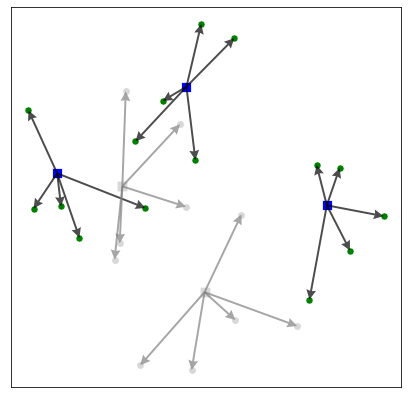

In [122]:
simulator.plot_network()

In [123]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-117.408590,-105.715905,-105.700880,-110.595353,-109.151495,-129.944970,-148.632739,-140.782806,-149.636671,-148.392224,...,-142.893604,-155.703989,-143.263149,-149.498031,-124.587197,-127.439705,-150.417218,-103.908980,-133.273786,-137.430345
1,-157.925296,-132.124191,-151.484620,-138.633251,-143.213606,-118.661009,-100.234685,-91.005800,-119.088605,-114.899927,...,-93.825155,-132.657010,-129.216221,-129.876123,-124.399304,-163.330254,-153.225923,-132.885019,-145.560608,-154.886462
2,-165.072047,-167.295836,-160.358352,-163.704828,-171.762016,-133.407936,-145.490010,-108.475884,-115.250154,-155.277103,...,-121.772559,-117.926022,-119.741658,-113.528854,-125.435089,-160.638706,-136.789130,-151.380621,-144.431595,-152.481394
3,-153.959362,-140.782952,-151.742302,-143.811600,-151.183102,-119.938728,-148.257173,-121.239494,-107.716845,-132.451705,...,-117.541329,-110.013386,-111.189895,-106.987638,-109.432413,-153.287672,-138.043472,-126.587452,-145.167588,-146.099073
4,-113.968109,-132.894960,-130.123804,-139.094772,-150.847396,-131.377864,-160.244323,-144.467366,-138.568491,-152.314942,...,-134.706200,-141.230588,-110.141044,-111.708100,-111.925973,-118.472151,-120.994351,-118.626547,-111.524473,-116.073030


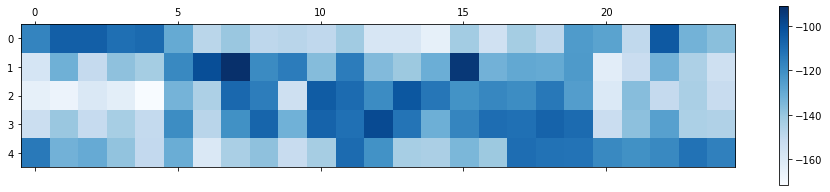

In [124]:
simulator.plot_gain_mat()

## Model Comparisons

In [125]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx))

159.9858637364371

In [126]:
# model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
# model_comparison.data_generation(num_samples=100, max_power=500, netB_power_mode='zero')
# model_comparison.modeling()

In [127]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='zero')

In [128]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='dependent')

In [129]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='uniform')

## Algorithm Comparisons

In [130]:
max_power = 200
netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'zero' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 300

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=False)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [131]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 1.086279879877774e-09
Weighted Sum Rate: 173.39901434080295
Power: [  0.           0.         150.64011363   0.           0.
   0.           0.         194.43744736   0.           0.
   0.           0.           0.          41.92070582   0.        ], [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Convergence Error at Round 300 0.6971593989254578


In [132]:
# rates_local_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='local',
#     interference_models=[],
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

In [133]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = [],
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: nan
Weighted Sum Rate: nan
Power: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan], [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Convergence Error at Round 300 nan


In [134]:
# rates_lr_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='lr_estimate',
#     interference_models=model_comparison.lr_models,
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

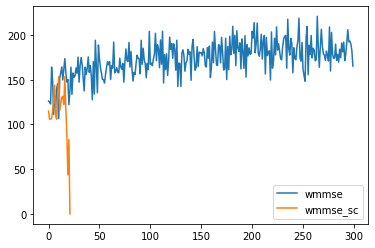

In [135]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    # 'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    # 'wmmse_lr': rates_lr_method,
})
data.plot();